In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_acoustic')
import enoki as ek
ek.cuda_set_log_level(0)

2021-06-10 10:43:02 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [3]:
def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "spectrum",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "smoothsphere",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                },
                "blur_size": .5
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox",
            "type": "obj",
            "filename": "../resources/cuberoom.obj",
            "bsdf": {
                "type": "ref",
                "id": "bsdf_neutral"
            },
            "to_world": transform(scale=np.array(box_dimensions))
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=False):
    return np.array(data, copy=copy).reshape(size)

In [4]:
from mitsuba.core.xml import load_string, load_dict

config = {
    "bins": [1],
    "absorption": 0.5,
    "scattering": 0.0,
    "max_time": 1,
    "time_steps": 100,
    "spp": 1000,
    "samples_per_pass": 1000,
    "box_dimensions": [5, 5, 5],
    "emitter_pos": [1, 1, 1],
    "sensor_pos": [-1, -1, -1],
    "radius": .1,  
    "max_depth": 50,
    "rfilter": {
        "type": "gaussian",
        "stddev": 2.0
    }
}

scene_dict = make_shoebox_scene(**config)
scene = load_dict(scene_dict)

size = scene.sensors()[0].film().size()

sensor = scene.sensors()[0]
integrator = scene.integrator()

status = integrator.render(scene, sensor)
assert status

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/acousticbsdf.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/sphere.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/smoothsphere.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/d65.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/regular.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/microphone.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/tape.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/gaussian.so" ..

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/obj.so" ..

2021-06-10 10:43:11 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-10 10:43:11 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-10 10:43:11 INFO main [PluginManager] Loading plugin "plugins/acousticpath.so" ..

2021-06-10 10:43:11 INFO main [Scene] Building scene in OptiX ..

2021-06-10 10:43:13 INFO main [TimeDependentIntegrator] Rendering finished. (took 1.501s)

In [5]:
film = sensor.film()
raw = film.bitmap(raw=True)
counts = film.bitmap(raw=False)
vals = get_vals(raw, film.size())
vals_count = get_vals(counts, film.size())

print("sum:", np.sum(vals))

energy = vals / (vals_count + 1e-8)
energy /= energy[0]
energy_db = 10 * (np.log(energy) / np.log(10))

sum: 18.898323


Text(0.5, 1.0, 'Counts')

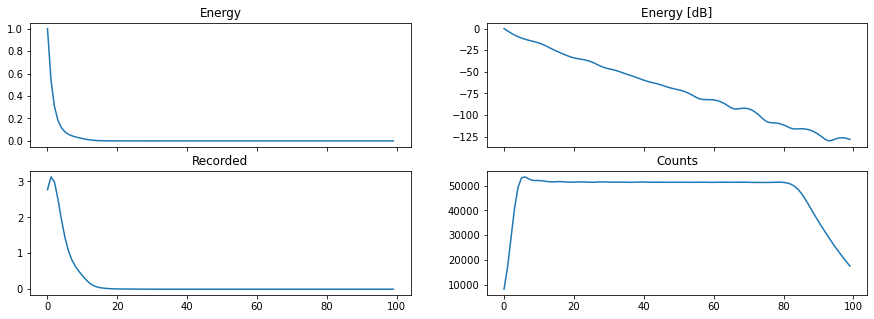

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(15, 5))
ax1.plot(energy)
ax1.set_title("Energy")
ax2.plot(energy_db)
ax2.set_title("Energy [dB]")
ax3.plot(vals)
ax3.set_title("Recorded")
ax4.plot(vals_count)
ax4.set_title("Counts")

In [7]:
energy

array([[1.0000000e+00],
       [5.4288191e-01],
       [3.0525064e-01],
       [1.8167879e-01],
       [1.1623743e-01],
       [8.0184482e-02],
       [5.8996424e-02],
       [4.5488879e-02],
       [3.5994805e-02],
       [2.8328430e-02],
       [2.1377064e-02],
       [1.5075899e-02],
       [9.8859537e-03],
       [6.1747539e-03],
       [3.8606152e-03],
       [2.5054477e-03],
       [1.6729474e-03],
       [1.1222188e-03],
       [7.6010154e-04],
       [5.3772703e-04],
       [4.0995388e-04],
       [3.3699043e-04],
       [2.8909012e-04],
       [2.4518752e-04],
       [1.9517838e-04],
       [1.4171706e-04],
       [9.4306866e-05],
       [5.9980768e-05],
       [3.9243532e-05],
       [2.8292694e-05],
       [2.2440217e-05],
       [1.8263137e-05],
       [1.4279634e-05],
       [1.0544567e-05],
       [7.5540524e-06],
       [5.4654606e-06],
       [4.0327468e-06],
       [2.9649057e-06],
       [2.1302221e-06],
       [1.5062254e-06],
       [1.0742465e-06],
       [7.927948